### Notebook description
In this notebook we are trying to replicate the work done in [The Cell-Type Specific Cortical Microcircuit: Relating Structure and Activity in a Full-Scale Spiking Network Model. Potjans, 2012 [1]](https://pubmed.ncbi.nlm.nih.gov/23203991/) using a spiking neuronal network (Nest3.0).
We are working with the model of connectivity detailed in [1], that can be seen in the figure below. For constructing the connections described in the figure we make use of the txt files, where are described the weights, number of connections, delays and number of neurons of each layer.

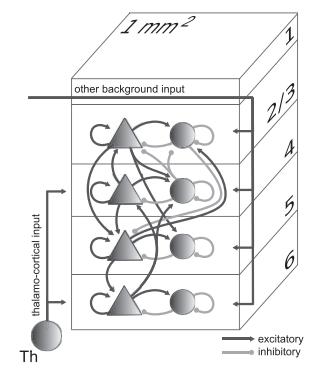


Necessary imports

In [1]:
import nest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer 
import os
import shutil
import scipy.io
from glob import glob


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.0
 Built: Jun 21 2022 22:42:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Block 1: Simulation. 

In [2]:
# Paths to files  **make sure to add a / after the path file name**
path_read_txt = "input_files/" # Directory where txts are located. In case you do not have this folder
                               # you can create it or set path_read_txt = "".
multimeters_path = "multimeter_out/" # Directory where multimeters files are located.
results_path = "results_folder/" # Directory where results are located.

# Seed
seed = np.random.randint(1000000)
np.random.seed(seed)

# Simulation parameters
dt = 1.0 # time resolution
simtime = 100.0 #ms

In [3]:
# Nest Kernel
nest.ResetKernel()
nest.SetKernelStatus({'rng_seed': seed})
nest.SetKernelStatus({"local_num_threads": 4})
nest.SetKernelStatus({'print_time':True}) # Show evolution of the simulation
nest.SetKernelStatus({"resolution": dt})
nest.SetKernelStatus({"overwrite_files": True})


Jul 12 16:36:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed.


Model definitions and parameters

In [4]:
# Neuron model
neuron_dict ={"I_e": 0.0, 
        "t_ref": 2.0, 
        "E_L":-65.0 , 
        "V_th":-50.0, 
        "tau_m": 10.0,
        "V_m": -60.0+10.0*np.random.rand()}
nest.SetDefaults("iaf_psc_delta", neuron_dict)

# Model definition
n_columns = 1
n_layers = 4
neuron_types = ["exc","inh"]
thalamic_input_layers = [2,4] # this indicates the index of the layer, but refers 
                              # to the L4 and L6 layers
                              
# Poisson generator parameters
noise_to_exc_rate = 8.0
noise_to_inh_rate = 8.0
thal_noise_rate = 0.0 # noise_to_exc_rate

# Weights 
w_gen_to_net= 0.08025 #0.085 this value lets the simulation work using the weights of the original paper
w_thal_driving= 0.0 # L4 and L6, for transient stimulation (15 Hz)
w_exc_to_exc_intra = 87.8 #87.8
w_exc_to_inh_intra = 87.8 #87.8
w_inh_to_inh_intra = -351.2 #-351.2 when balanced; -200 when unbalanced
w_inh_to_exc_intra = -351.2 #-351.2 when balanced; -200 when unbalanced
w_inter=1 
k_scaling_Ed_card = 0.01 # (divider) for weight matrix 

# Delays 
Ed_speed = 5.10

# Distribution for neurons
k_scaling_P_D_neurons = 1 # 1 # (divider) number previously used: 77
k_scaling_P_D_edges = 0.000125 # 1 # (divider) number previously used: 0.125

Read txt files

In [5]:
# total volume of nodes (can be useful to scale the groups)
N_card_vector = np.ones(n_columns) 
#subdivision of neurons in the pools. Order: L2/3e L2/3i L4e L4i L5e L5i L6e L6i
pop_card_vector = np.loadtxt(path_read_txt + 'P_D_cardinality.txt') / k_scaling_P_D_neurons
# connections between pools of the same node
conn_intra_matrix = np.transpose(np.loadtxt(path_read_txt + 'P_D_connectivity.txt'))/k_scaling_P_D_edges
conn_Ed_card_matrix = np.int_(np.loadtxt(path_read_txt + 'inter_weights.txt')/k_scaling_Ed_card)
conn_Ed_lgth_matrix = np.loadtxt(path_read_txt + 'inter_lengths.txt') / Ed_speed
P_D_input = np.loadtxt(path_read_txt + 'P_D_input.txt')

Create Nest devices

In [6]:
# Poisson generators (each one sends an independent train to the specified number of "outdegree" neurons of the target population)

# Generator to excitatory neurons
noise_to_exc = nest.Create("poisson_generator")
nest.SetStatus(noise_to_exc, {"rate": noise_to_exc_rate}) # rate [spikes/s], it will generate a unique 
                                                          # spike train for each of it’s targets

# Generator to inhibitory neurons
noise_to_inh = nest.Create("poisson_generator")
nest.SetStatus(noise_to_inh, {"rate": noise_to_inh_rate})

poisson_generators = [noise_to_exc,noise_to_inh]

# Thalamic noise
thal_noise = nest.Create("poisson_generator")
nest.SetStatus(thal_noise, {"rate": thal_noise_rate})

# Detectors 
mult = nest.Create("multimeter",
                params={"interval": dt,
                        "record_from": ["V_m"],
                        #"withgid": True,
                        #"to_file": True,
                        #"to_memory": False,
                        "label": "my_multimeter"})

spikedet = nest.Create('spike_recorder',
                params={#"withgid": True, 
                        #"withtime": True,
                        #"to_file": False,
                        #"to_memory": True,
                        "label": "my_spike_recorder"})

mult.record_to = "ascii"
spikedet.record_to = "memory"

Create population dictionary

In [7]:
# Create the dictionary of the neuron populations in each pool for each node 
# Each key is defined like "neuron_pop_ + exc or inh (excitatory or inhibitory) + column number + layer number"
  
neuron_pop_dict = {} 
for col_num in range(1,n_columns + 1): 
    for layer_num in range(1,n_layers + 1): 
        for i,neuron_type in enumerate(neuron_types):
            layer_name = 'neuron_pop_' + neuron_type + str(col_num) + '_' + str(layer_num)
            population_size = int(N_card_vector[col_num-1]*pop_card_vector[2*(layer_num - 1)+i])
            neuron_pop_dict[layer_name] = nest.Create("iaf_psc_delta", population_size)

Connections

In [8]:
connections_time_start = timer() 
for col_num in range(1,n_columns+1): 

    # Devices connections 
    for layer_num in range(1,n_layers+1): 
        for i,(neuron_type,poiss_type) in enumerate(zip(neuron_types,poisson_generators)):
            connection_dict = {'rule': 'fixed_total_number', 
                                   'N': int(P_D_input[0, 2*(layer_num-1)+i] * pop_card_vector[2*(layer_num-1)+i])}
            pop_name = 'neuron_pop_' + neuron_type + str(col_num) + '_' + str(layer_num)
            nest.Connect(poiss_type, neuron_pop_dict[pop_name], 
                         conn_spec= connection_dict, 
                         syn_spec= {"weight": w_gen_to_net})
            

        if layer_num in thalamic_input_layers: #thalamic_gen_to columns 
            pop_name = 'neuron_pop_' + neuron_type + str(col_num) + '_' + str(layer_num)
            nest.Connect(thal_noise, neuron_pop_dict[pop_name], 
                         conn_spec=connection_dict, 
                         syn_spec= {"weight": w_thal_driving})

    
    # Intra-node Connections:  (order: L2/3e L2/3i L4e L4i L5e L5i L6e L6i)
    for layer_num in range(1,n_layers+1): 
        for i, target_neuron_type in enumerate(neuron_types):
            target_pop_name = 'neuron_pop_' + target_neuron_type + str(col_num) + '_' + str(layer_num)
            target_pop = neuron_pop_dict[target_pop_name]
        
            for source_layer in range(1,n_layers+1): 
                for j, source_neuron_type in enumerate(neuron_types):
                    
                    source_pop_name = 'neuron_pop_' + source_neuron_type + str(col_num) + '_' + str(source_layer)
                    source_pop = neuron_pop_dict[source_pop_name]
                
                    if source_neuron_type == "exc" and target_neuron_type == "exc":
                        weights_dict = w_exc_to_exc_intra
                    elif source_neuron_type == "inh" and target_neuron_type == "exc":
                        weights_dict = w_inh_to_exc_intra
                    elif source_neuron_type == "exc" and target_neuron_type == "inh":
                        weights_dict = w_exc_to_inh_intra
                    elif source_neuron_type == "inh" and target_neuron_type == "inh":
                        weights_dict = w_inh_to_inh_intra
                    else: 
                        raise ValueError("Neurontype error in Intra-node Connections")

                    nest.Connect(source_pop, target_pop, 
                                conn_spec={'rule': 'fixed_total_number', 
                                           'N':int(conn_intra_matrix[layer_num, source_layer] * k_scaling_P_D_neurons)}, 
                                syn_spec={"weight": weights_dict})  
    
    # Inter-node connections: exc_to_exc connections only
    for target_col in range(1,n_columns+1):
        if target_col != col_num: # we have already intra-node connections
            for source_layer_num in range(1,n_layers+1):        
                for target_layer_num in range(1,n_layers+1):     
                    source_pop_name = 'neuron_pop_exc' + str(col_num) + '_' + str(source_layer_num)
                    target_pop_name = 'neuron_pop_exc' + str(target_col) + '_' + str(target_layer_num)
                    
                    nest.Connect(neuron_pop_dict[source_pop_name], neuron_pop_dict[target_pop_name], 
                                conn_spec={'rule': 'fixed_total_number', 
                                           'N':conn_Ed_card_matrix[layer_num, target_col-1]}, 
                                syn_spec={"weight":w_inter, 
                                          "delay":conn_Ed_lgth_matrix[layer_num, target_col-1]}) 

# Net to spike detector
for column in range(1,n_columns+1):
    for layer in range(1,n_layers+1): 
        for neuron_type in neuron_types:
            nest.Connect(neuron_pop_dict['neuron_pop_' + neuron_type + str(column)  + '_' + str(layer)], spikedet)

# Multimeter to net
for column in range(1,n_columns+1): 
    for layer in range(1,n_layers+1): 
        for neuron_type in neuron_types:
            nest.Connect(mult, neuron_pop_dict['neuron_pop_' + neuron_type + str(column) + '_' + str(layer)])


connections_time_end = timer() 
print("\nConnections execution time: ", connections_time_end - connections_time_start, "s")


Connections execution time:  55.01979311500054 s


Simulation

In [9]:
sim_time_start = timer() 
nest.Simulate(simtime)
sim_time_end = timer()


Jul 12 16:37:02 NodeManager::prepare_nodes [Info]: 
    Preparing 77189 nodes for simulation.

Jul 12 16:37:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 77189
    Simulation time (ms): 100
    Number of OpenMP threads: 4
    Not using MPI

[ 100% ] Model time: 100.0 ms, Real-time factor: 4276.1571

Jul 12 16:44:10 SimulationManager::run [Info]: 
    Simulation finished.


In [10]:
print("Simulation execution time: ", sim_time_end - sim_time_start, "s") 

Simulation execution time:  428.397805607 s


### Block 2. Results. 

In [11]:
def create_folder(path_name):
    if not os.path.exists(path_name):
        os.makedirs(path_name)

def remove_folder_contents(path_name):
    for filename in os.listdir(path_name):
        file_path = os.path.join(path_name, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            continue

def plot_events_times(times,events,name,path):
    fig = plt.figure()
    plt.clf() # Clear previous plot
    plt.plot(times,events,".", markersize=2)
    plt.xlabel("time (ms)")
    plt.ylabel("Spike events")
    plt.savefig(path + "/plot_time_events_" + name + ".png")
    plt.close(fig) # for not displaying the image
    return None

def plot_barchart(data_column,layer_names,y_label,title):
    y_pos = np.arange(len(layer_names))
    plt.bar(y_pos, df[data_column], align='center', alpha=0.5, 
        color=["dodgerblue","lightblue"])
    plt.xticks(y_pos, layer_names)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    return None

Folder to save plots and results

In [12]:
create_folder(results_path)
#remove_folder_contents(results_path)

Get events and times from spike detectors

In [13]:
dSD = nest.GetStatus(spikedet,keys="events")[0]
events = dSD["senders"]
times = dSD["times"]
# _ = plot_events_times(times,events,"joint",results_path)

In [14]:
# The index of neurons are fixed by nest so we need to get them to count how many 
# spikes a layer has sent. 

count_spikes = []
irregularity = [] # definition of coefficient of variation: Coefficient of variation vs. mean interspike interval curves: What do they tell us about the brain? Chris Christodoulou, Guido Bugmann
synchrony = [] # Potjans 2012
for column in range(1,n_columns+1):
    for layer_num in range(1,n_layers+1):
        for neuron_type in neuron_types:
            pop_name = "neuron_pop_" + neuron_type + str(column) + "_" + str(layer_num)
            layer_bounds = neuron_pop_dict[pop_name].global_id[0],neuron_pop_dict[pop_name].global_id[-1]
            idx = np.where((layer_bounds[1]>=events) & (events>=layer_bounds[0]))
            
            count_spikes.append(len(events[idx]))
            
            interspike_intervals = np.diff(np.sort(times[idx]))/1000
            irregularity.append(np.std(interspike_intervals)/(np.mean(interspike_intervals)))
            
            counts, bins= np.histogram(events[idx], bins = 3)
            synchrony.append(np.var(counts)/np.mean(counts))


# Rename count_dict keys
layer_names = ["L23e","L23i","L4e","L4i","L5e","L5i","L6e","L6i"]
count_dict = dict(zip(layer_names,count_spikes)) 


# Get firing rates, irregularity and synchrony
firing_rates_dict = {}
irregularity_dict = {}
synchrony_dict = {}

# this tells us the average firing rate per neuron of each layer 
# (we need to scale it by the number of neurons in each layer described in pop_card_vector)
firing_rates_dict.update((x, count_dict[x]/y * 1000 / simtime ) for x, y in zip(count_dict.keys(),pop_card_vector))
irregularity_dict.update((x, y) for x, y in zip(layer_names,irregularity))
synchrony_dict.update((x, y) for x, y in zip(layer_names,synchrony))

df = pd.DataFrame([firing_rates_dict,irregularity_dict, synchrony_dict], 
                  index = ["mean firing rate","irregularity","synchrony"]).transpose()

# Average firing rate per neuron considering all neurons
FR_avg = len(events)/( int(np.sum(pop_card_vector))) * 1000 / simtime 

        
print("\nThe average firing rate is", np.around(FR_avg,4)) # print in console
for key, value in firing_rates_dict.items(): # print in console
    print (f"The {key} firing rate is", np.around(value,4))


The average firing rate is 4.0289
The L23e firing rate is 4.3466
The L23i firing rate is 1.3678
The L4e firing rate is 4.3701
The L4i firing rate is 1.6445
The L5e firing rate is 5.8742
The L5i firing rate is 10.1408
The L6e firing rate is 4.3522
The L6i firing rate is 2.1404


In [15]:
df

,mean firing rate,irregularity,synchrony
L23e,4.346565,10.296208,0.359585
L23i,1.367844,3.078952,0.368421
L4e,4.370066,10.823751,0.284501
L4i,1.644461,3.223725,0.244913
L5e,5.874227,5.807900,1.249795
L5i,10.140845,3.533766,0.140741
L6e,4.352206,8.825874,0.720298
L6i,2.140434,2.698893,1.338616


Plot barchart for firing rates

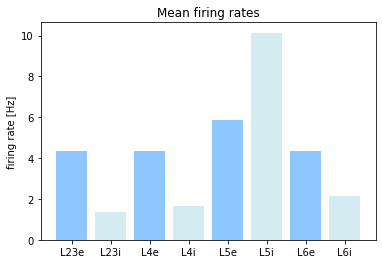

In [16]:
plot_barchart("mean firing rate",layer_names,'firing rate [Hz]','Mean firing rates')

Plot barchart for irregularity

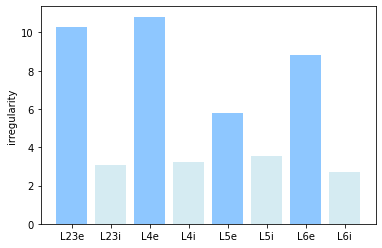

In [17]:
plot_barchart("irregularity",layer_names,'irregularity',"")

Plot barchart for synchrony

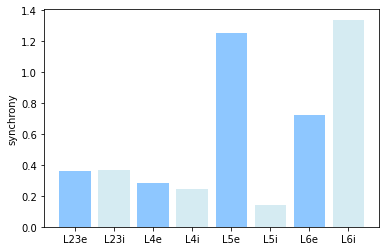

In [18]:
plot_barchart("synchrony",layer_names,'synchrony',"")

### Block 3. Extract signals.